In [ ]:
# Install required libraries
import sys
print("Installing required packages...")

# Install necessary packages
!pip install -q nltk scikit-learn imbalanced-learn wordcloud matplotlib seaborn pandas numpy

print("All packages installed successfully!")

Installing required packages...
All packages installed successfully!


In [ ]:
# Core data manipulation and analysis
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

# Natural Language Processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download required NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omegaconf', quiet=True)

# Machine Learning - Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Machine Learning - Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier

# Machine Learning - Data Splitting and Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix,
                             roc_auc_score, roc_curve)

# Handling Imbalanced Data
from imblearn.over_sampling import SMOTE

# Clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Model Persistence
import joblib

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("All libraries imported successfully!")
print(f"Python version: {sys.version}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

All libraries imported successfully!
Python version: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Pandas version: 2.2.2
NumPy version: 2.0.2


[nltk_data] Error loading omegaconf: Package 'omegaconf' not found in
[nltk_data]     index


In [ ]:
from google.colab import files
import io

print("="*80)
print("DATASET UPLOAD SECTION")
print("="*80)
print("\nPlease upload the following 5 CSV files:")
print("1. Constraint_English_Train.csv")
print("2. Constraint_English_Test.csv")
print("3. Constraint_English_Val.csv")
print("4. Fake.csv")
print("5. True.csv")
print("\nClick 'Choose Files' and select all 5 files together.")
print("="*80)

uploaded = files.upload()

print("\n[SUCCESS] Files uploaded successfully!")
print(f"Uploaded files: {list(uploaded.keys())}")

DATASET UPLOAD SECTION

Please upload the following 5 CSV files:
1. Constraint_English_Train.csv
2. Constraint_English_Test.csv
3. Constraint_English_Val.csv
4. Fake.csv
5. True.csv

Click 'Choose Files' and select all 5 files together.


Saving Constraint_English_Test.csv to Constraint_English_Test.csv
Saving Constraint_English_Train.csv to Constraint_English_Train.csv
Saving Constraint_English_Val.csv to Constraint_English_Val.csv
Saving Fake.csv to Fake.csv
Saving True.csv to True.csv

[SUCCESS] Files uploaded successfully!
Uploaded files: ['Constraint_English_Test.csv', 'Constraint_English_Train.csv', 'Constraint_English_Val.csv', 'Fake.csv', 'True.csv']


In [ ]:
print("\n" + "="*80)
print("LOADING AND EXPLORING DATASETS")
print("="*80)

# Load Constraint datasets
print("\n[INFO] Loading Constraint datasets...")
constraint_train = pd.read_csv('Constraint_English_Train.csv')
constraint_test = pd.read_csv('Constraint_English_Test.csv')
constraint_val = pd.read_csv('Constraint_English_Val.csv')

print(f"Constraint Train shape: {constraint_train.shape}")
print(f"Constraint Test shape: {constraint_test.shape}")
print(f"Constraint Val shape: {constraint_val.shape}")

# Display sample from Constraint dataset
print("\nConstraint Train Sample:")
print(constraint_train.head(3))
print(f"\nConstraint Label Distribution:\n{constraint_train['label'].value_counts()}")

# Load Kaggle Fake and True datasets
print("\n[INFO] Loading Kaggle Fake and True datasets...")
fake_df = pd.read_csv('Fake.csv')
true_df = pd.read_csv('True.csv')

print(f"Fake News shape: {fake_df.shape}")
print(f"True News shape: {true_df.shape}")

# Display sample from Kaggle datasets
print("\nFake News Sample:")
print(fake_df.head(3))
print("\nTrue News Sample:")
print(true_df.head(3))

print("\n[SUCCESS] All datasets loaded successfully!")


LOADING AND EXPLORING DATASETS

[INFO] Loading Constraint datasets...
Constraint Train shape: (6420, 3)
Constraint Test shape: (2140, 3)
Constraint Val shape: (2140, 3)

Constraint Train Sample:
   id                                              tweet label
0   1  The CDC currently reports 99031 deaths. In gen...  real
1   2  States reported 1121 deaths a small rise from ...  real
2   3  Politically Correct Woman (Almost) Uses Pandem...  fake

Constraint Label Distribution:
label
real    3360
fake    3060
Name: count, dtype: int64

[INFO] Loading Kaggle Fake and True datasets...
Fake News shape: (7000, 4)
True News shape: (7000, 4)

Fake News Sample:
                                               title  \
0  GANGSTA GOV ATTEMPTS SHAKEDOWN OF GIANT MORTGA...   
1  HOUSE DEMOCRATS MAKE STUNNING Move To Implemen...   
2  3 MILLION ILLEGAL ALIENS Under Investigation F...   

                                                text          subject  \
0  Quicken Loans owner, Dan Gilbert is one

In [ ]:
print("\n" + "="*80)
print("DATA PREPROCESSING AND MERGING")
print("="*80)

# Combine Constraint datasets
print("\n[INFO] Combining Constraint datasets...")
constraint_combined = pd.concat([constraint_train, constraint_test, constraint_val],
                                ignore_index=True)

# Standardize Constraint dataset format
constraint_combined['label'] = constraint_combined['label'].map({'real': 0, 'fake': 1})
constraint_combined = constraint_combined[['tweet', 'label']].rename(columns={'tweet': 'text'})
constraint_combined['source'] = 'Constraint'

print(f"Combined Constraint dataset shape: {constraint_combined.shape}")
print(f"Label distribution:\n{constraint_combined['label'].value_counts()}")

# Process Kaggle Fake dataset
print("\n[INFO] Processing Kaggle Fake dataset...")
fake_df['label'] = 1
fake_df['text'] = fake_df['title'] + ' ' + fake_df['text']
fake_df = fake_df[['text', 'label']]
fake_df['source'] = 'Kaggle_Fake'

print(f"Processed Fake dataset shape: {fake_df.shape}")

# Process Kaggle True dataset
print("\n[INFO] Processing Kaggle True dataset...")
true_df['label'] = 0
true_df['text'] = true_df['title'] + ' ' + true_df['text']
true_df = true_df[['text', 'label']]
true_df['source'] = 'Kaggle_True'

print(f"Processed True dataset shape: {true_df.shape}")

# Combine all datasets
print("\n[INFO] Combining all datasets into master dataset...")
master_df = pd.concat([constraint_combined, fake_df, true_df], ignore_index=True)

# Remove any null values
initial_shape = master_df.shape
master_df.dropna(subset=['text', 'label'], inplace=True)
master_df = master_df[master_df['text'].str.strip() != '']

print(f"\nInitial combined shape: {initial_shape}")
print(f"After removing nulls: {master_df.shape}")
print(f"\nFinal Label Distribution:")
print(master_df['label'].value_counts())
print(f"\nDataset Source Distribution:")
print(master_df['source'].value_counts())

# Display summary statistics
print("\n[INFO] Dataset Summary:")
print(master_df.describe())

print("\n[SUCCESS] Data preprocessing and merging complete!")


DATA PREPROCESSING AND MERGING

[INFO] Combining Constraint datasets...
Combined Constraint dataset shape: (10700, 3)
Label distribution:
label
0    5600
1    5100
Name: count, dtype: int64

[INFO] Processing Kaggle Fake dataset...
Processed Fake dataset shape: (7000, 3)

[INFO] Processing Kaggle True dataset...
Processed True dataset shape: (7000, 3)

[INFO] Combining all datasets into master dataset...

Initial combined shape: (24700, 3)
After removing nulls: (24700, 3)

Final Label Distribution:
label
0    12600
1    12100
Name: count, dtype: int64

Dataset Source Distribution:
source
Constraint     10700
Kaggle_Fake     7000
Kaggle_True     7000
Name: count, dtype: int64

[INFO] Dataset Summary:
              label
count  24700.000000
mean       0.489879
std        0.499908
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000

[SUCCESS] Data preprocessing and merging complete!


In [ ]:
print("\n" + "="*80)
print("TEXT CLEANING AND FEATURE ENGINEERING")
print("="*80)

# Initialize NLP tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def advanced_text_cleaning(text):
    """
    Comprehensive text cleaning function for misinformation detection.

    Steps:
    1. Convert to lowercase
    2. Remove URLs, email addresses
    3. Remove mentions and hashtags
    4. Remove special characters and numbers
    5. Tokenize
    6. Remove stopwords
    7. Lemmatize words
    8. Remove short words (less than 3 characters)

    Parameters:
        text (str): Raw text input

    Returns:
        str: Cleaned text
    """
    if not isinstance(text, str):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # Remove mentions
    text = re.sub(r'@\w+', '', text)

    # Remove hashtags but keep the word
    text = re.sub(r'#', '', text)

    # Remove special characters and numbers, keep only alphabets and spaces
    text = re.sub(r'[^a-z\s]', '', text)

    # Tokenize
    tokens = text.split()

    # Remove stopwords and short words
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

    # Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return " ".join(tokens)

def calculate_text_features(text):
    """
    Calculate additional text-based features for enhanced model performance.

    Features:
    - Text length
    - Word count
    - Average word length
    - Punctuation count
    - Capital letter count
    - Question mark count
    - Exclamation mark count

    Parameters:
        text (str): Original text

    Returns:
        dict: Dictionary of calculated features
    """
    if not isinstance(text, str):
        return {
            'text_length': 0,
            'word_count': 0,
            'avg_word_length': 0,
            'punctuation_count': 0,
            'capital_count': 0,
            'question_marks': 0,
            'exclamation_marks': 0
        }

    words = text.split()

    return {
        'text_length': len(text),
        'word_count': len(words),
        'avg_word_length': np.mean([len(word) for word in words]) if words else 0,
        'punctuation_count': sum(1 for char in text if char in '.,!?;:'),
        'capital_count': sum(1 for char in text if char.isupper()),
        'question_marks': text.count('?'),
        'exclamation_marks': text.count('!')
    }

# Apply text cleaning
print("\n[INFO] Applying advanced text cleaning to all texts...")
print("This may take a few minutes...")

master_df['cleaned_text'] = master_df['text'].apply(advanced_text_cleaning)

# Remove rows where cleaned text is empty
initial_rows = len(master_df)
master_df = master_df[master_df['cleaned_text'].str.len() > 0]
removed_rows = initial_rows - len(master_df)

print(f"[SUCCESS] Text cleaning complete!")
print(f"Removed {removed_rows} rows with no meaningful content")
print(f"Final dataset shape: {master_df.shape}")

# Calculate additional features
print("\n[INFO] Calculating additional text features...")
feature_dicts = master_df['text'].apply(calculate_text_features)
feature_df = pd.DataFrame(feature_dicts.tolist())

# Merge feature_df with master_df
master_df = pd.concat([master_df.reset_index(drop=True),
                       feature_df.reset_index(drop=True)], axis=1)

print("[SUCCESS] Additional features calculated!")
print("\nFeature Statistics:")
print(feature_df.describe())

# Display sample of cleaned data
print("\n[INFO] Sample of Original vs Cleaned Text:")
sample_df = master_df[['text', 'cleaned_text', 'label']].head(3)
for idx, row in sample_df.iterrows():
    print(f"\n--- Sample {idx + 1} ---")
    print(f"Label: {'FAKE' if row['label'] == 1 else 'REAL'}")
    print(f"Original: {row['text'][:200]}...")
    print(f"Cleaned: {row['cleaned_text'][:200]}...")

print("\n[SUCCESS] Text cleaning and feature engineering complete!")


TEXT CLEANING AND FEATURE ENGINEERING

[INFO] Applying advanced text cleaning to all texts...
This may take a few minutes...
[SUCCESS] Text cleaning complete!
Removed 3 rows with no meaningful content
Final dataset shape: (24697, 4)

[INFO] Calculating additional text features...
[SUCCESS] Additional features calculated!

Feature Statistics:
        text_length    word_count  avg_word_length  punctuation_count  \
count  24697.000000  24697.000000     24697.000000       24697.000000   
mean    1514.229259    246.962991         5.481616          26.923877   
std     1934.321000    317.188421         0.971641          35.699359   
min       18.000000      3.000000         3.400000           0.000000   
25%      187.000000     28.000000         4.934457           3.000000   
50%      634.000000    102.000000         5.215278          11.000000   
75%     2449.000000    402.000000         5.659164          42.000000   
max    51893.000000   8148.000000        18.090909         936.000000  


EXPLORATORY DATA ANALYSIS AND VISUALIZATION

[INFO] Creating label distribution chart...
[INFO] Creating text length distribution...
[INFO] Creating word count distribution...
[INFO] Creating dataset source distribution...
[INFO] Creating average word length comparison...
[INFO] Creating punctuation usage comparison...


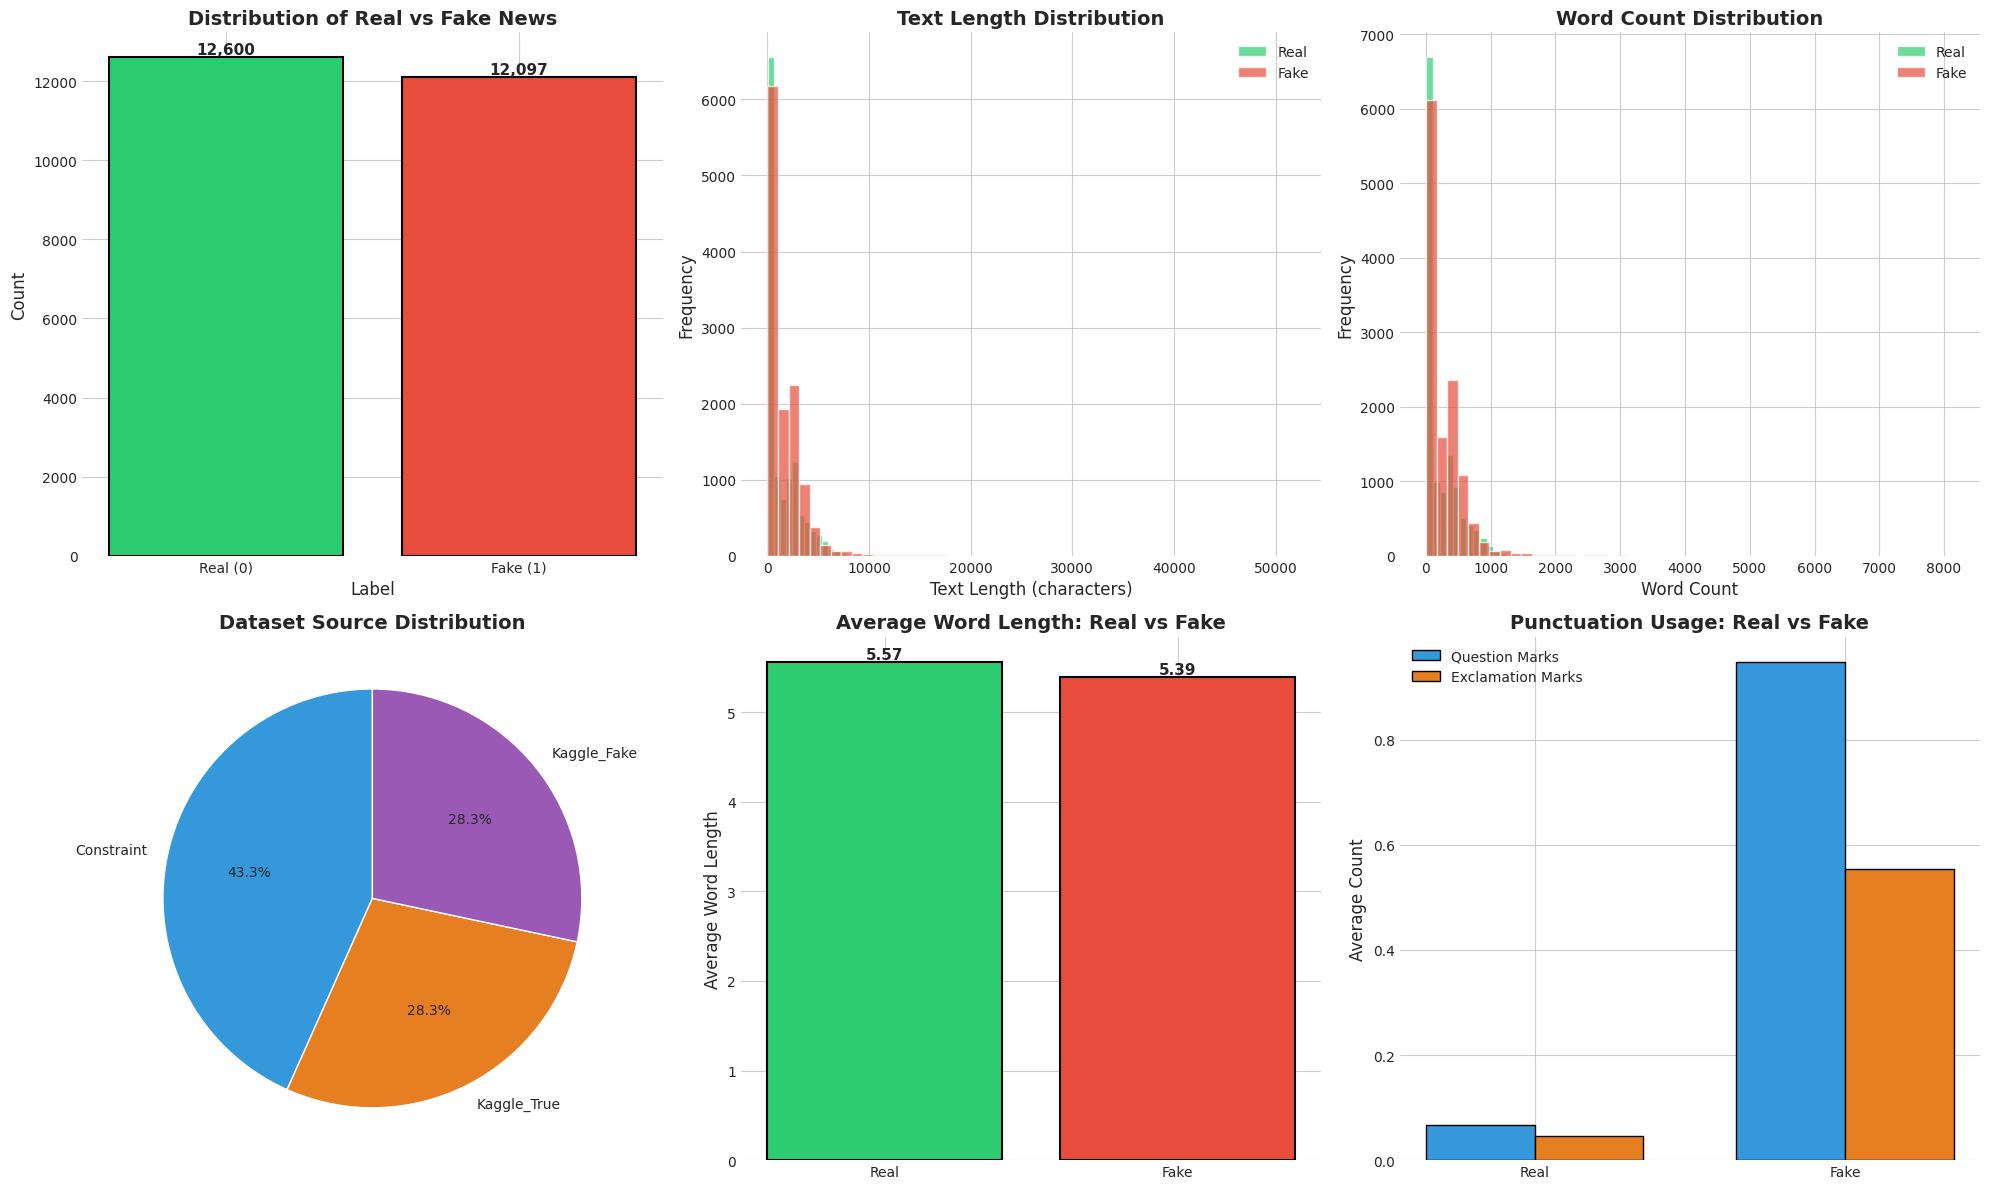


[SUCCESS] EDA visualizations created and saved as 'eda_visualization.png'

STATISTICAL SUMMARY

Text Features by Label:
       text_length  word_count  avg_word_length  punctuation_count  \
label                                                                
0      1450.132857  232.787619         5.565680          25.116349   
1      1580.990824  261.727784         5.394057          28.806564   

       capital_count  
label                 
0          57.820000  
1          79.717368  

[SUCCESS] Exploratory Data Analysis complete!


In [ ]:
print("\n" + "="*80)
print("EXPLORATORY DATA ANALYSIS AND VISUALIZATION")
print("="*80)

# Create a figure for multiple subplots
fig = plt.figure(figsize=(20, 12))

# 1. Label Distribution
print("\n[INFO] Creating label distribution chart...")
ax1 = plt.subplot(2, 3, 1)
label_counts = master_df['label'].value_counts()
colors = ['#2ecc71', '#e74c3c']
bars = ax1.bar(['Real (0)', 'Fake (1)'], label_counts.values, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_title('Distribution of Real vs Fake News', fontsize=14, fontweight='bold')
ax1.set_ylabel('Count', fontsize=12)
ax1.set_xlabel('Label', fontsize=12)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# 2. Text Length Distribution
print("[INFO] Creating text length distribution...")
ax2 = plt.subplot(2, 3, 2)
master_df[master_df['label'] == 0]['text_length'].hist(bins=50, alpha=0.7,
                                                         label='Real', color='#2ecc71', ax=ax2)
master_df[master_df['label'] == 1]['text_length'].hist(bins=50, alpha=0.7,
                                                         label='Fake', color='#e74c3c', ax=ax2)
ax2.set_title('Text Length Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Text Length (characters)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.legend()

# 3. Word Count Distribution
print("[INFO] Creating word count distribution...")
ax3 = plt.subplot(2, 3, 3)
master_df[master_df['label'] == 0]['word_count'].hist(bins=50, alpha=0.7,
                                                        label='Real', color='#2ecc71', ax=ax3)
master_df[master_df['label'] == 1]['word_count'].hist(bins=50, alpha=0.7,
                                                        label='Fake', color='#e74c3c', ax=ax3)
ax3.set_title('Word Count Distribution', fontsize=14, fontweight='bold')
ax3.set_xlabel('Word Count', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.legend()

# 4. Dataset Source Distribution
print("[INFO] Creating dataset source distribution...")
ax4 = plt.subplot(2, 3, 4)
source_counts = master_df['source'].value_counts()
ax4.pie(source_counts.values, labels=source_counts.index, autopct='%1.1f%%',
        startangle=90, colors=['#3498db', '#e67e22', '#9b59b6'])
ax4.set_title('Dataset Source Distribution', fontsize=14, fontweight='bold')

# 5. Average Word Length Comparison
print("[INFO] Creating average word length comparison...")
ax5 = plt.subplot(2, 3, 5)
avg_word_length_comparison = master_df.groupby('label')['avg_word_length'].mean()
bars = ax5.bar(['Real', 'Fake'], avg_word_length_comparison.values,
               color=['#2ecc71', '#e74c3c'], edgecolor='black', linewidth=1.5)
ax5.set_title('Average Word Length: Real vs Fake', fontsize=14, fontweight='bold')
ax5.set_ylabel('Average Word Length', fontsize=12)

for bar in bars:
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# 6. Punctuation Usage Comparison
print("[INFO] Creating punctuation usage comparison...")
ax6 = plt.subplot(2, 3, 6)
punctuation_comparison = master_df.groupby('label')[['question_marks', 'exclamation_marks']].mean()
x = np.arange(2)
width = 0.35
bars1 = ax6.bar(x - width/2, punctuation_comparison['question_marks'], width,
                label='Question Marks', color='#3498db', edgecolor='black')
bars2 = ax6.bar(x + width/2, punctuation_comparison['exclamation_marks'], width,
                label='Exclamation Marks', color='#e67e22', edgecolor='black')
ax6.set_title('Punctuation Usage: Real vs Fake', fontsize=14, fontweight='bold')
ax6.set_ylabel('Average Count', fontsize=12)
ax6.set_xticks(x)
ax6.set_xticklabels(['Real', 'Fake'])
ax6.legend()

plt.tight_layout()
plt.savefig('eda_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n[SUCCESS] EDA visualizations created and saved as 'eda_visualization.png'")

# Print statistical summary
print("\n" + "="*80)
print("STATISTICAL SUMMARY")
print("="*80)

print("\nText Features by Label:")
print(master_df.groupby('label')[['text_length', 'word_count', 'avg_word_length',
                                   'punctuation_count', 'capital_count']].mean())

print("\n[SUCCESS] Exploratory Data Analysis complete!")


GENERATING WORD CLOUDS
[INFO] Generating word clouds...
[INFO] Creating word cloud for Real news...
[INFO] Creating word cloud for Fake news...


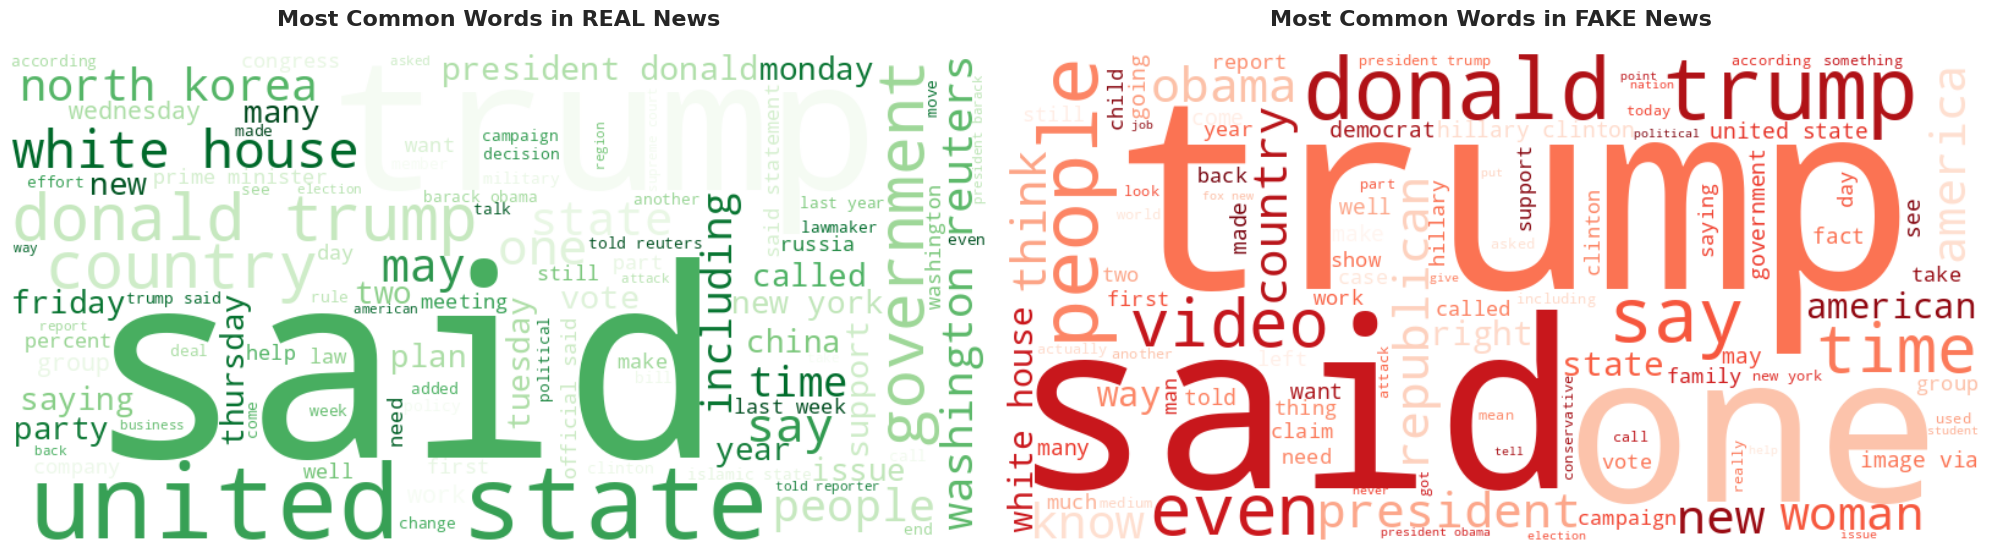


[SUCCESS] Word clouds created and saved as 'wordclouds.png'


In [ ]:
print("\n" + "="*80)
print("GENERATING WORD CLOUDS")
print("="*80)

# Prepare text for word clouds
real_text = ' '.join(master_df[master_df['label'] == 0]['cleaned_text'].values)
fake_text = ' '.join(master_df[master_df['label'] == 1]['cleaned_text'].values)

print("[INFO] Generating word clouds...")

# Create figure for word clouds
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Word cloud for Real news
print("[INFO] Creating word cloud for Real news...")
wordcloud_real = WordCloud(width=800, height=400,
                           background_color='white',
                           colormap='Greens',
                           max_words=100,
                           relative_scaling=0.5,
                           min_font_size=10).generate(real_text)

axes[0].imshow(wordcloud_real, interpolation='bilinear')
axes[0].set_title('Most Common Words in REAL News', fontsize=16, fontweight='bold', pad=20)
axes[0].axis('off')

# Word cloud for Fake news
print("[INFO] Creating word cloud for Fake news...")
wordcloud_fake = WordCloud(width=800, height=400,
                           background_color='white',
                           colormap='Reds',
                           max_words=100,
                           relative_scaling=0.5,
                           min_font_size=10).generate(fake_text)

axes[1].imshow(wordcloud_fake, interpolation='bilinear')
axes[1].set_title('Most Common Words in FAKE News', fontsize=16, fontweight='bold', pad=20)
axes[1].axis('off')

plt.tight_layout()
plt.savefig('wordclouds.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n[SUCCESS] Word clouds created and saved as 'wordclouds.png'")

In [ ]:
print("\n" + "="*80)
print("DATA SPLITTING AND VECTORIZATION")
print("="*80)

# Prepare features and target
X = master_df['cleaned_text']
y = master_df['label']

print(f"Total samples: {len(X)}")
print(f"Label distribution:\n{y.value_counts()}")

# Split data into training and testing sets (80-20 split)
print("\n[INFO] Splitting data into training and testing sets (80-20 split)...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
print(f"\nTraining set label distribution:\n{y_train.value_counts()}")
print(f"\nTesting set label distribution:\n{y_test.value_counts()}")

# TF-IDF Vectorization
print("\n[INFO] Vectorizing text using TF-IDF...")
print("Parameters:")
print("  - max_features: 5000")
print("  - ngram_range: (1, 2) [unigrams and bigrams]")
print("  - min_df: 2 [word must appear in at least 2 documents]")
print("  - max_df: 0.95 [word must not appear in more than 95% of documents]")

vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    strip_accents='unicode',
    lowercase=True,
    analyzer='word',
    token_pattern=r'\w{1,}',
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=True
)

# Fit on training data only to prevent data leakage
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"\n[SUCCESS] Vectorization complete!")
print(f"Training TF-IDF matrix shape: {X_train_tfidf.shape}")
print(f"Testing TF-IDF matrix shape: {X_test_tfidf.shape}")
print(f"Vocabulary size: {len(vectorizer.vocabulary_)}")

# Display top features
feature_names = vectorizer.get_feature_names_out()
print(f"\nSample features: {list(feature_names[:20])}")

print("\n[SUCCESS] Data splitting and vectorization complete!")


DATA SPLITTING AND VECTORIZATION
Total samples: 24697
Label distribution:
label
0    12600
1    12097
Name: count, dtype: int64

[INFO] Splitting data into training and testing sets (80-20 split)...
Training set size: 19757
Testing set size: 4940

Training set label distribution:
label
0    10080
1     9677
Name: count, dtype: int64

Testing set label distribution:
label
0    2520
1    2420
Name: count, dtype: int64

[INFO] Vectorizing text using TF-IDF...
Parameters:
  - max_features: 5000
  - ngram_range: (1, 2) [unigrams and bigrams]
  - min_df: 2 [word must appear in at least 2 documents]
  - max_df: 0.95 [word must not appear in more than 95% of documents]

[SUCCESS] Vectorization complete!
Training TF-IDF matrix shape: (19757, 5000)
Testing TF-IDF matrix shape: (4940, 5000)
Vocabulary size: 5000

Sample features: ['abandon', 'abbas', 'abc', 'abc news', 'abe', 'abedin', 'ability', 'able', 'abortion', 'abroad', 'absence', 'absolute', 'absolutely', 'abuse', 'academic', 'academy', '


HANDLING CLASS IMBALANCE WITH SMOTE
Original training set distribution:
label
0    10080
1     9677
Name: count, dtype: int64

Imbalance ratio: 1.04:1

[INFO] Applying SMOTE to balance the training dataset...

[SUCCESS] SMOTE applied successfully!
Resampled training set distribution:
label
1    10080
0    10080
Name: count, dtype: int64

New balance ratio: 1:1 (Perfect balance)
Resampled training set shape: (20160, 5000)


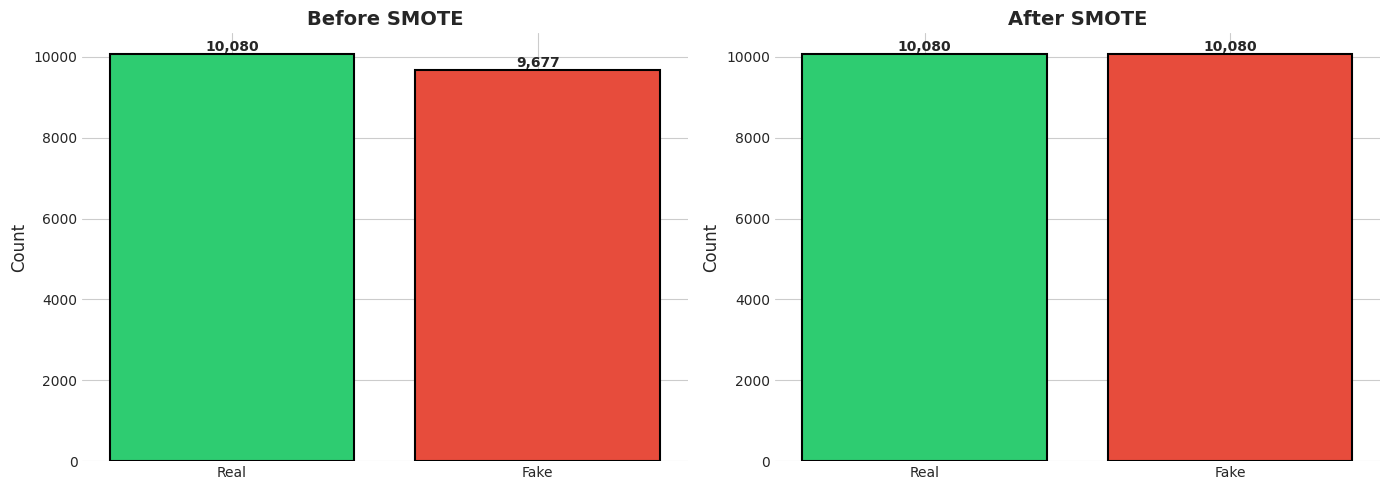


[SUCCESS] Class imbalance handling complete!


In [ ]:
print("\n" + "="*80)
print("HANDLING CLASS IMBALANCE WITH SMOTE")
print("="*80)

print(f"Original training set distribution:")
print(y_train.value_counts())
print(f"\nImbalance ratio: {y_train.value_counts()[0] / y_train.value_counts()[1]:.2f}:1")

# Apply SMOTE only to training data
print("\n[INFO] Applying SMOTE to balance the training dataset...")
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

print(f"\n[SUCCESS] SMOTE applied successfully!")
print(f"Resampled training set distribution:")
print(pd.Series(y_train_resampled).value_counts())
print(f"\nNew balance ratio: 1:1 (Perfect balance)")
print(f"Resampled training set shape: {X_train_resampled.shape}")

# Visualize the effect of SMOTE
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before SMOTE
axes[0].bar(['Real', 'Fake'], y_train.value_counts().values,
            color=['#2ecc71', '#e74c3c'], edgecolor='black', linewidth=1.5)
axes[0].set_title('Before SMOTE', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12)
for i, v in enumerate(y_train.value_counts().values):
    axes[0].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# After SMOTE
axes[1].bar(['Real', 'Fake'], pd.Series(y_train_resampled).value_counts().values,
            color=['#2ecc71', '#e74c3c'], edgecolor='black', linewidth=1.5)
axes[1].set_title('After SMOTE', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Count', fontsize=12)
for i, v in enumerate(pd.Series(y_train_resampled).value_counts().values):
    axes[1].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('smote_effect.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n[SUCCESS] Class imbalance handling complete!")

In [ ]:
print("\n" + "="*80)
print("TRAINING CLASSIFICATION MODELS")
print("="*80)

# Define models to train
models_dict = {
    "Logistic Regression": LogisticRegression(
        random_state=42,
        max_iter=1000,
        C=1.0,
        solver='liblinear'
    ),
    "Multinomial Naive Bayes": MultinomialNB(
        alpha=1.0
    ),
    "Support Vector Machine": SVC(
        kernel='linear',
        random_state=42,
        C=1.0,
        probability=True
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=100,
        random_state=42,
        learning_rate=0.1,
        max_depth=5
    )
}

# Store results and trained models
classification_results = {}
trained_models = {}
predictions_dict = {}

print(f"\n[INFO] Training {len(models_dict)} classification models...")

for model_name, model in models_dict.items():
    print(f"\n{'='*60}")
    print(f"Training: {model_name}")
    print(f"{'='*60}")

    # Train the model
    print(f"[INFO] Fitting {model_name} to training data...")
    model.fit(X_train_resampled, y_train_resampled)

    # Make predictions
    print(f"[INFO] Generating predictions...")
    y_pred = model.predict(X_test_tfidf)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Store results
    classification_results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

    trained_models[model_name] = model
    predictions_dict[model_name] = y_pred

    # Display results
    print(f"\n[RESULTS] {model_name}:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")

    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred,
                                target_names=['Real', 'Fake'],
                                digits=4))

print("\n" + "="*80)
print("[SUCCESS] All classification models trained successfully!")
print("="*80)

# Create results DataFrame
results_df = pd.DataFrame(classification_results).T
print("\n" + "="*80)
print("CLASSIFICATION MODELS COMPARISON")
print("="*80)
print(results_df.to_string())

# Identify best model
best_model_name = results_df['Accuracy'].idxmax()
best_accuracy = results_df['Accuracy'].max()

print(f"\n[RESULT] Best Classification Model: {best_model_name}")
print(f"[RESULT] Best Accuracy: {best_accuracy:.4f}")


TRAINING CLASSIFICATION MODELS

[INFO] Training 5 classification models...

Training: Logistic Regression
[INFO] Fitting Logistic Regression to training data...
[INFO] Generating predictions...

[RESULTS] Logistic Regression:
  Accuracy:  0.9395
  Precision: 0.9395
  Recall:    0.9395
  F1-Score:  0.9395

Classification Report:
              precision    recall  f1-score   support

        Real     0.9440    0.9369    0.9405      2520
        Fake     0.9348    0.9421    0.9385      2420

    accuracy                         0.9395      4940
   macro avg     0.9394    0.9395    0.9395      4940
weighted avg     0.9395    0.9395    0.9395      4940


Training: Multinomial Naive Bayes
[INFO] Fitting Multinomial Naive Bayes to training data...
[INFO] Generating predictions...

[RESULTS] Multinomial Naive Bayes:
  Accuracy:  0.8939
  Precision: 0.8940
  Recall:    0.8939
  F1-Score:  0.8939

Classification Report:
              precision    recall  f1-score   support

        Real     0.8


VISUALIZING CLASSIFICATION MODEL PERFORMANCE


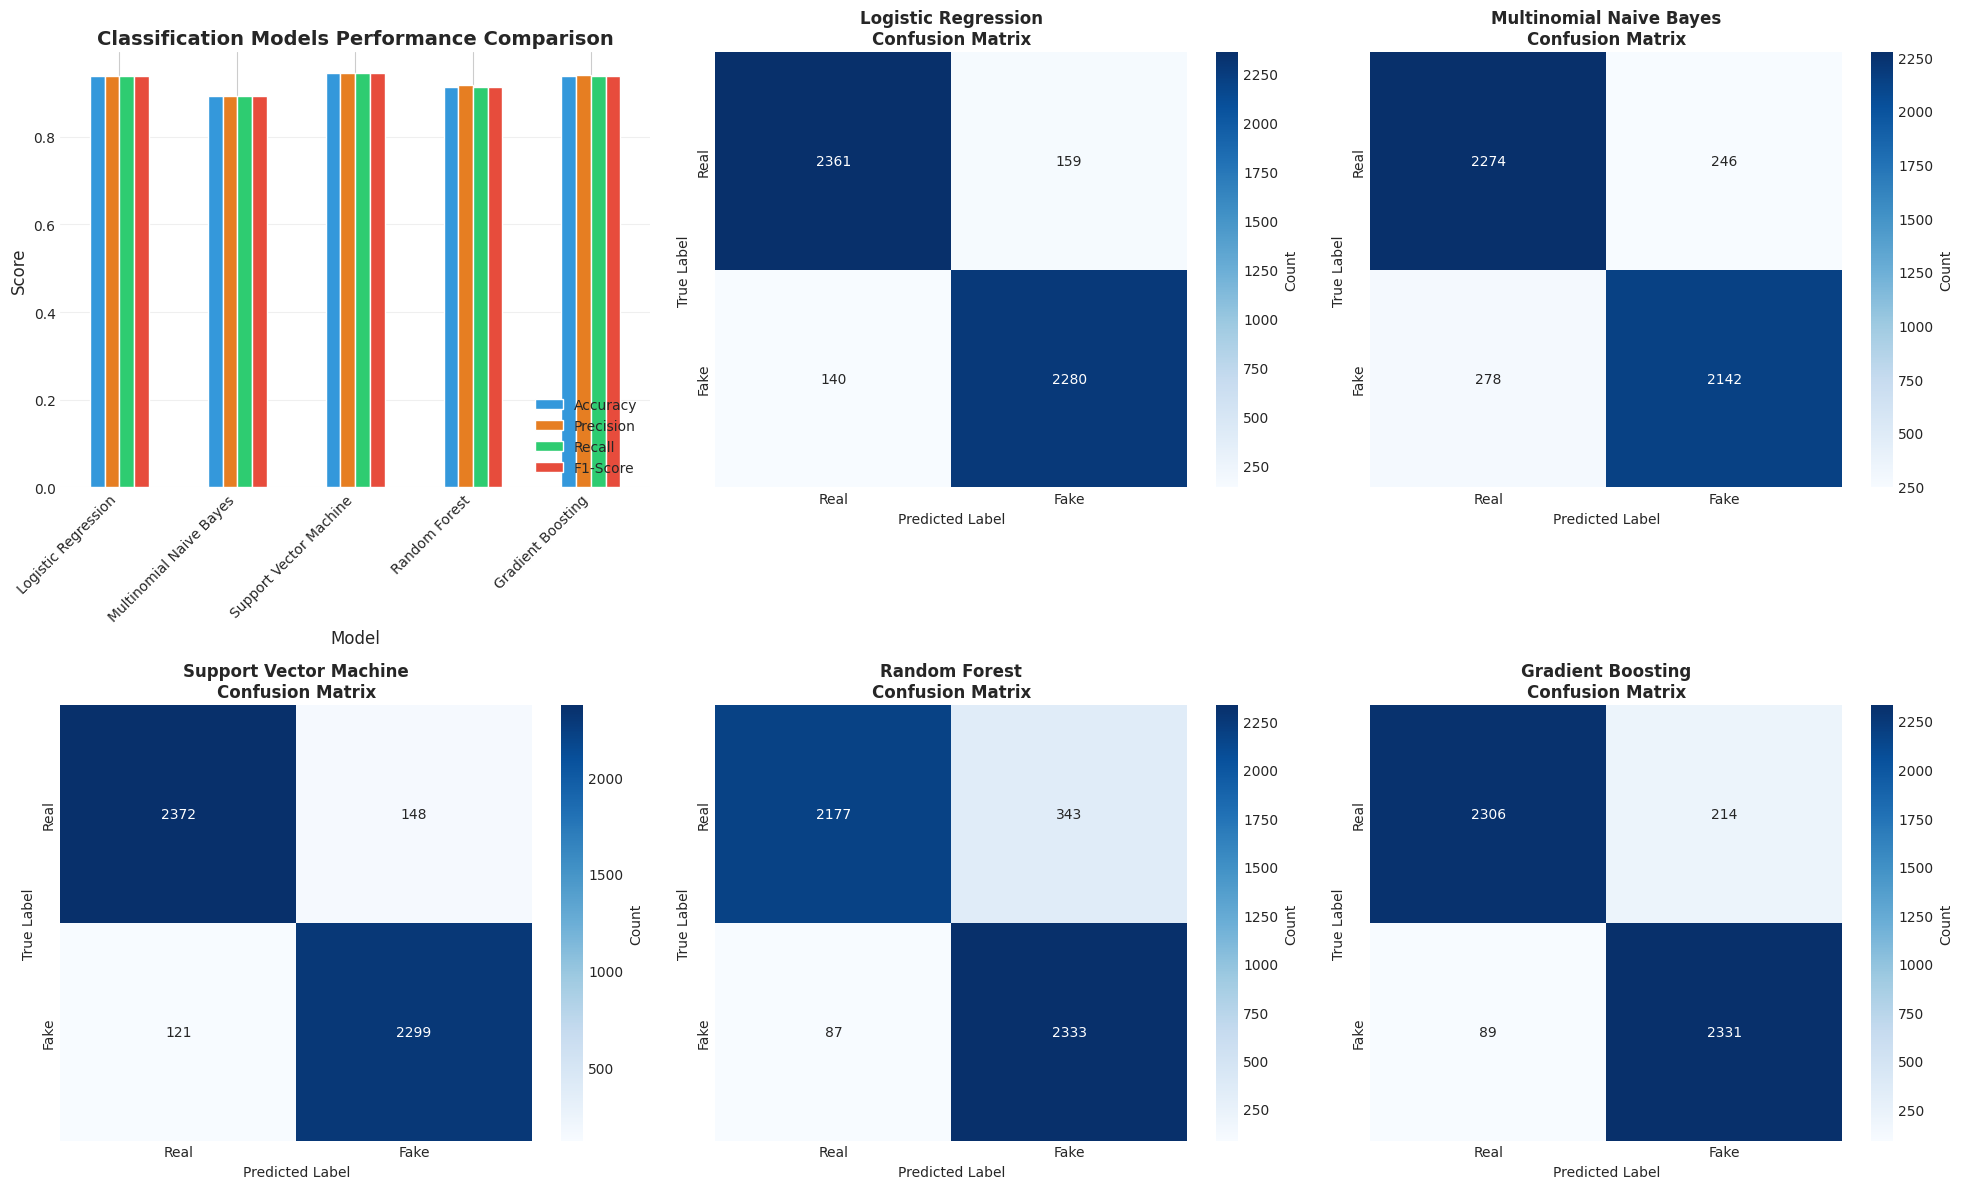


[SUCCESS] Classification performance visualization saved as 'classification_results.png'


In [ ]:
print("\n" + "="*80)
print("VISUALIZING CLASSIFICATION MODEL PERFORMANCE")
print("="*80)

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 12))

# 1. Model Comparison Bar Chart
ax1 = plt.subplot(2, 3, 1)
results_df.plot(kind='bar', ax=ax1, color=['#3498db', '#e67e22', '#2ecc71', '#e74c3c'])
ax1.set_title('Classification Models Performance Comparison', fontsize=14, fontweight='bold')
ax1.set_xlabel('Model', fontsize=12)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_xticklabels(results_df.index, rotation=45, ha='right')
ax1.legend(loc='lower right')
ax1.grid(axis='y', alpha=0.3)

# 2-6. Confusion Matrices for each model
for idx, (model_name, y_pred) in enumerate(predictions_dict.items(), start=2):
    ax = plt.subplot(2, 3, idx)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Real', 'Fake'],
                yticklabels=['Real', 'Fake'],
                cbar_kws={'label': 'Count'})
    ax.set_title(f'{model_name}\nConfusion Matrix', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=10)
    ax.set_xlabel('Predicted Label', fontsize=10)

plt.tight_layout()
plt.savefig('classification_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n[SUCCESS] Classification performance visualization saved as 'classification_results.png'")


CLUSTERING ANALYSIS (K-MEANS)
[INFO] Applying PCA for dimensionality reduction...
[SUCCESS] PCA applied. Reduced to 50 components
Explained variance ratio: 0.1687

[INFO] Applying K-Means clustering with k=2...

[INFO] Analyzing cluster purity...

Training Data - Cluster Distribution:
Cluster        0     1
True Label            
0           4485  5595
1           4231  5849

Testing Data - Cluster Distribution:
Cluster        0     1
True Label            
0           1082  1438
1           1001  1419

[RESULT] Training Cluster Purity: 0.5126
[RESULT] Testing Cluster Purity: 0.5101

[INFO] Creating cluster visualization...


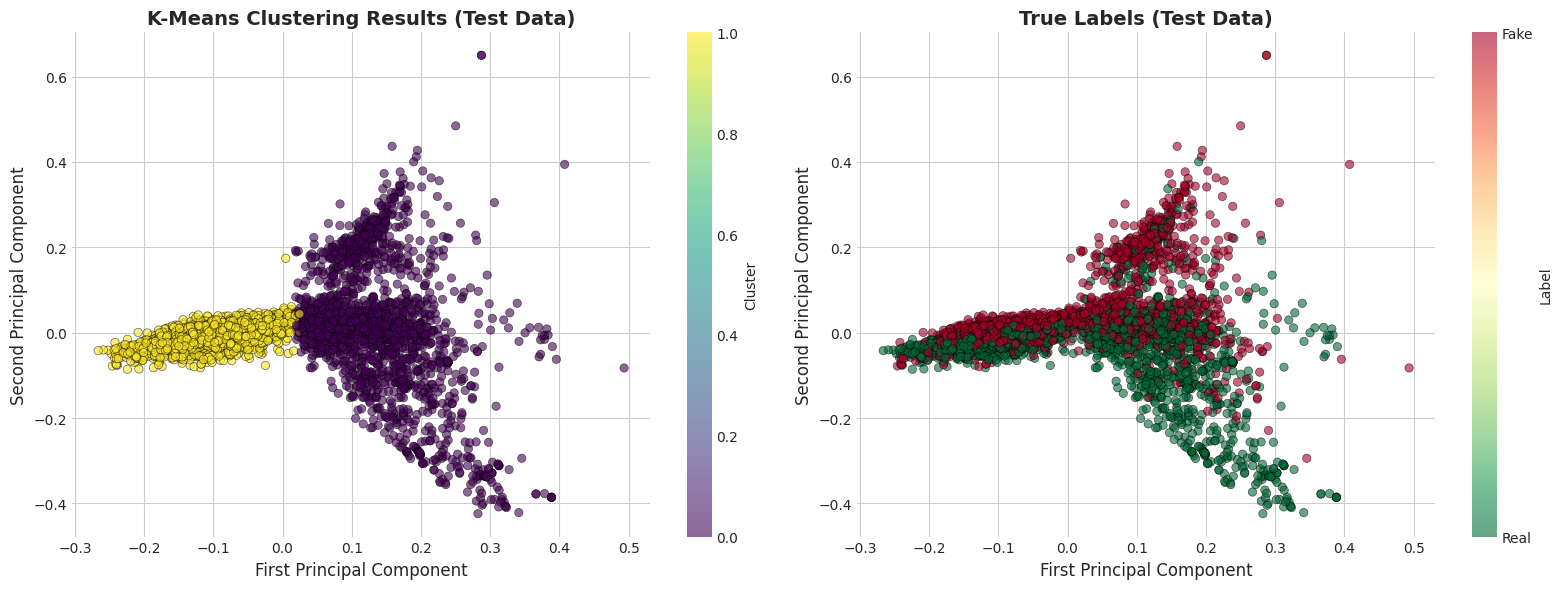


[SUCCESS] Clustering analysis complete!
[SUCCESS] Visualization saved as 'clustering_results.png'


In [ ]:
print("\n" + "="*80)
print("CLUSTERING ANALYSIS (K-MEANS)")
print("="*80)

# Use PCA for dimensionality reduction before clustering
print("[INFO] Applying PCA for dimensionality reduction...")
pca = PCA(n_components=50, random_state=42)
X_train_pca = pca.fit_transform(X_train_resampled.toarray())
X_test_pca = pca.transform(X_test_tfidf.toarray())

print(f"[SUCCESS] PCA applied. Reduced to {pca.n_components_} components")
print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")

# Apply K-Means clustering
print("\n[INFO] Applying K-Means clustering with k=2...")
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10, max_iter=300)
kmeans_train_clusters = kmeans.fit_predict(X_train_pca)
kmeans_test_clusters = kmeans.predict(X_test_pca)

# Analyze cluster purity
print("\n[INFO] Analyzing cluster purity...")

# For training data
train_cluster_df = pd.DataFrame({
    'True_Label': y_train_resampled,
    'Cluster': kmeans_train_clusters
})

print("\nTraining Data - Cluster Distribution:")
print(pd.crosstab(train_cluster_df['True_Label'], train_cluster_df['Cluster'],
                  rownames=['True Label'], colnames=['Cluster']))

# For testing data
test_cluster_df = pd.DataFrame({
    'True_Label': y_test,
    'Cluster': kmeans_test_clusters
})

print("\nTesting Data - Cluster Distribution:")
print(pd.crosstab(test_cluster_df['True_Label'], test_cluster_df['Cluster'],
                  rownames=['True Label'], colnames=['Cluster']))

# Calculate clustering purity
def calculate_purity(true_labels, cluster_labels):
    """Calculate clustering purity score."""
    contingency_matrix = pd.crosstab(true_labels, cluster_labels)
    return np.sum(np.amax(contingency_matrix.values, axis=0)) / np.sum(contingency_matrix.values)

train_purity = calculate_purity(y_train_resampled, kmeans_train_clusters)
test_purity = calculate_purity(y_test, kmeans_test_clusters)

print(f"\n[RESULT] Training Cluster Purity: {train_purity:.4f}")
print(f"[RESULT] Testing Cluster Purity: {test_purity:.4f}")

# Visualize clusters
print("\n[INFO] Creating cluster visualization...")

# Further reduce to 2D for visualization
pca_2d = PCA(n_components=2, random_state=42)
X_test_2d = pca_2d.fit_transform(X_test_pca)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Clusters
scatter1 = axes[0].scatter(X_test_2d[:, 0], X_test_2d[:, 1],
                           c=kmeans_test_clusters, cmap='viridis',
                           alpha=0.6, edgecolors='black', linewidth=0.5)
axes[0].set_title('K-Means Clustering Results (Test Data)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('First Principal Component', fontsize=12)
axes[0].set_ylabel('Second Principal Component', fontsize=12)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Plot 2: True Labels
scatter2 = axes[1].scatter(X_test_2d[:, 0], X_test_2d[:, 1],
                           c=y_test, cmap='RdYlGn_r',
                           alpha=0.6, edgecolors='black', linewidth=0.5)
axes[1].set_title('True Labels (Test Data)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('First Principal Component', fontsize=12)
axes[1].set_ylabel('Second Principal Component', fontsize=12)
cbar = plt.colorbar(scatter2, ax=axes[1], label='Label', ticks=[0, 1])
cbar.ax.set_yticklabels(['Real', 'Fake'])

plt.tight_layout()
plt.savefig('clustering_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n[SUCCESS] Clustering analysis complete!")
print("[SUCCESS] Visualization saved as 'clustering_results.png'")

In [ ]:
print("\n" + "="*80)
print("CREATING ENSEMBLE MODEL (VOTING CLASSIFIER)")
print("="*80)

# Select top 3 models for ensemble based on F1-Score
top_models = results_df.nlargest(3, 'F1-Score')
print(f"[INFO] Top 3 models selected for ensemble:")
print(top_models[['Accuracy', 'F1-Score']])

# Create voting classifier
estimators = [
    ('lr', LogisticRegression(random_state=42, max_iter=1000, solver='liblinear')),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42, max_depth=20)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
]

print("\n[INFO] Creating Voting Classifier with soft voting...")
ensemble_model = VotingClassifier(
    estimators=estimators,
    voting='soft',
    n_jobs=-1
)

print("[INFO] Training ensemble model...")
ensemble_model.fit(X_train_resampled, y_train_resampled)

print("[INFO] Generating predictions with ensemble model...")
ensemble_predictions = ensemble_model.predict(X_test_tfidf)

# Evaluate ensemble model
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
ensemble_precision = precision_score(y_test, ensemble_predictions, average='weighted')
ensemble_recall = recall_score(y_test, ensemble_predictions, average='weighted')
ensemble_f1 = f1_score(y_test, ensemble_predictions, average='weighted')

print("\n" + "="*80)
print("ENSEMBLE MODEL PERFORMANCE")
print("="*80)
print(f"Accuracy:  {ensemble_accuracy:.4f}")
print(f"Precision: {ensemble_precision:.4f}")
print(f"Recall:    {ensemble_recall:.4f}")
print(f"F1-Score:  {ensemble_f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, ensemble_predictions,
                            target_names=['Real', 'Fake'],
                            digits=4))

# Add ensemble results to comparison
classification_results['Ensemble (Voting)'] = {
    'Accuracy': ensemble_accuracy,
    'Precision': ensemble_precision,
    'Recall': ensemble_recall,
    'F1-Score': ensemble_f1
}

trained_models['Ensemble (Voting)'] = ensemble_model

# Update results DataFrame
final_results_df = pd.DataFrame(classification_results).T
print("\n" + "="*80)
print("FINAL MODEL COMPARISON (INCLUDING ENSEMBLE)")
print("="*80)
print(final_results_df.to_string())

# Identify overall best model
overall_best_model = final_results_df['F1-Score'].idxmax()
overall_best_f1 = final_results_df['F1-Score'].max()

print(f"\n[FINAL RESULT] Best Overall Model: {overall_best_model}")
print(f"[FINAL RESULT] Best F1-Score: {overall_best_f1:.4f}")

print("\n[SUCCESS] Ensemble model created and evaluated!")


CREATING ENSEMBLE MODEL (VOTING CLASSIFIER)
[INFO] Top 3 models selected for ensemble:
                        Accuracy  F1-Score
Support Vector Machine  0.945547  0.945551
Logistic Regression     0.939474  0.939478
Gradient Boosting       0.938664  0.938656

[INFO] Creating Voting Classifier with soft voting...
[INFO] Training ensemble model...
[INFO] Generating predictions with ensemble model...

ENSEMBLE MODEL PERFORMANCE
Accuracy:  0.9413
Precision: 0.9422
Recall:    0.9413
F1-Score:  0.9413

Classification Report:
              precision    recall  f1-score   support

        Real     0.9623    0.9210    0.9412      2520
        Fake     0.9213    0.9624    0.9414      2420

    accuracy                         0.9413      4940
   macro avg     0.9418    0.9417    0.9413      4940
weighted avg     0.9422    0.9413    0.9413      4940


FINAL MODEL COMPARISON (INCLUDING ENSEMBLE)
                         Accuracy  Precision    Recall  F1-Score
Logistic Regression      0.939474   0

In [ ]:
print("\n" + "="*80)
print("SAVING BEST MODEL AND VECTORIZER")
print("="*80)

# Determine the best model
best_model_name = final_results_df['F1-Score'].idxmax()
best_model = trained_models[best_model_name]

print(f"[INFO] Best model identified: {best_model_name}")
print(f"[INFO] F1-Score: {final_results_df.loc[best_model_name, 'F1-Score']:.4f}")

# Save the best model
model_filename = 'best_misinfo_detection_model.joblib'
joblib.dump(best_model, model_filename)
print(f"\n[SUCCESS] Model saved as: {model_filename}")

# Save the TF-IDF vectorizer
vectorizer_filename = 'tfidf_vectorizer.joblib'
joblib.dump(vectorizer, vectorizer_filename)
print(f"[SUCCESS] Vectorizer saved as: {vectorizer_filename}")

# Save model metadata
metadata = {
    'model_name': best_model_name,
    'accuracy': final_results_df.loc[best_model_name, 'Accuracy'],
    'precision': final_results_df.loc[best_model_name, 'Precision'],
    'recall': final_results_df.loc[best_model_name, 'Recall'],
    'f1_score': final_results_df.loc[best_model_name, 'F1-Score'],
    'training_samples': X_train_resampled.shape[0],  # Fixed: use .shape[0] instead of len()
    'testing_samples': len(X_test),
    'vocabulary_size': len(vectorizer.vocabulary_),
    'feature_extraction': 'TF-IDF',
    'max_features': 5000,
    'ngram_range': '(1, 2)'
}

metadata_filename = 'model_metadata.joblib'
joblib.dump(metadata, metadata_filename)
print(f"[SUCCESS] Model metadata saved as: {metadata_filename}")

# Download files
print("\n[INFO] Preparing files for download...")
files.download(model_filename)
files.download(vectorizer_filename)
files.download(metadata_filename)

print("\n[SUCCESS] All model files saved and ready for download!")


SAVING BEST MODEL AND VECTORIZER
[INFO] Best model identified: Support Vector Machine
[INFO] F1-Score: 0.9456

[SUCCESS] Model saved as: best_misinfo_detection_model.joblib
[SUCCESS] Vectorizer saved as: tfidf_vectorizer.joblib
[SUCCESS] Model metadata saved as: model_metadata.joblib

[INFO] Preparing files for download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


[SUCCESS] All model files saved and ready for download!


In [ ]:
print("\n" + "="*80)
print("INTERACTIVE MISINFORMATION DETECTION SYSTEM")
print("="*80)

def predict_misinformation(text, model, vectorizer, threshold=0.6):
    """
    Predict whether a given text is misinformation or not.

    Parameters:
        text (str): Input text to analyze
        model: Trained classification model
        vectorizer: Fitted TF-IDF vectorizer
        threshold (float): Confidence threshold for classification

    Returns:
        dict: Prediction results with confidence score
    """
    # Clean the input text
    cleaned = advanced_text_cleaning(text)

    if not cleaned:
        return {
            'status': 'error',
            'message': 'No meaningful content found after cleaning.'
        }

    # Vectorize
    text_tfidf = vectorizer.transform([cleaned])

    # Predict
    prediction = model.predict(text_tfidf)[0]

    # Get probability if available
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(text_tfidf)[0]
        confidence = probabilities[prediction]
    else:
        confidence = 1.0

    # Determine verdict
    if prediction == 1:
        if confidence >= threshold:
            verdict = "FAKE NEWS"
            color = "RED"
        else:
            verdict = "LIKELY FAKE"
            color = "ORANGE"
    else:
        if confidence >= threshold:
            verdict = "REAL NEWS"
            color = "GREEN"
        else:
            verdict = "LIKELY REAL"
            color = "LIGHT GREEN"

    return {
        'status': 'success',
        'prediction': int(prediction),
        'verdict': verdict,
        'confidence': confidence,
        'color': color,
        'cleaned_text': cleaned
    }

def ensemble_prediction(text, models_dict, vectorizer):
    """
    Get predictions from all models and calculate consensus.

    Parameters:
        text (str): Input text
        models_dict (dict): Dictionary of trained models
        vectorizer: TF-IDF vectorizer

    Returns:
        dict: Ensemble prediction results
    """
    # Clean text
    cleaned = advanced_text_cleaning(text)

    if not cleaned:
        return {
            'status': 'error',
            'message': 'No meaningful content found.'
        }

    # Vectorize
    text_tfidf = vectorizer.transform([cleaned])

    # Get predictions from all models
    predictions = []
    individual_results = {}

    for name, model in models_dict.items():
        pred = model.predict(text_tfidf)[0]
        predictions.append(pred)
        individual_results[name] = 'FAKE' if pred == 1 else 'REAL'

    # Calculate consensus
    fake_count = sum(predictions)
    real_count = len(predictions) - fake_count

    consensus_prediction = 1 if fake_count > real_count else 0
    consensus_percentage = (max(fake_count, real_count) / len(predictions)) * 100

    return {
        'status': 'success',
        'consensus_prediction': consensus_prediction,
        'consensus_verdict': 'FAKE NEWS' if consensus_prediction == 1 else 'REAL NEWS',
        'consensus_percentage': consensus_percentage,
        'individual_results': individual_results,
        'vote_breakdown': {
            'fake_votes': fake_count,
            'real_votes': real_count
        }
    }

# Interactive testing loop
print("\n" + "="*60)
print(" LIVE MISINFORMATION DETECTION SYSTEM")
print(" Type 'exit' to quit")
print(" Type 'ensemble' to enable ensemble mode")
print("="*60)

use_ensemble = False

while True:
    print("\n" + "-"*60)
    user_input = input("\nEnter news text to analyze (or command):\n> ")

    if user_input.lower() == 'exit':
        print("\n[INFO] Exiting detection system. Goodbye!")
        break

    if user_input.lower() == 'ensemble':
        use_ensemble = not use_ensemble
        mode = "ENABLED" if use_ensemble else "DISABLED"
        print(f"\n[INFO] Ensemble mode {mode}")
        continue

    if not user_input.strip():
        print("[ERROR] Please enter some text.")
        continue

    print("\n" + "="*60)
    print("ANALYSIS RESULTS")
    print("="*60)

    if use_ensemble:
        # Use ensemble prediction
        result = ensemble_prediction(user_input, trained_models, vectorizer)

        if result['status'] == 'error':
            print(f"\n[ERROR] {result['message']}")
        else:
            print(f"\nCONSENSUS VERDICT: {result['consensus_verdict']}")
            print(f"Consensus Strength: {result['consensus_percentage']:.1f}%")
            print(f"\nVote Breakdown:")
            print(f"  Real News:  {result['vote_breakdown']['real_votes']} votes")
            print(f"  Fake News:  {result['vote_breakdown']['fake_votes']} votes")
            print(f"\nIndividual Model Predictions:")
            for model_name, prediction in result['individual_results'].items():
                print(f"  {model_name:<25}: {prediction}")
    else:
        # Use best model prediction
        result = predict_misinformation(user_input, best_model, vectorizer)

        if result['status'] == 'error':
            print(f"\n[ERROR] {result['message']}")
        else:
            print(f"\nVERDICT: {result['verdict']}")
            print(f"Confidence: {result['confidence']:.2%}")
            print(f"Classification: {'Fake (1)' if result['prediction'] == 1 else 'Real (0)'}")

    print("="*60)

print("\n[SUCCESS] Interactive prediction system demonstration complete!")


INTERACTIVE MISINFORMATION DETECTION SYSTEM

 LIVE MISINFORMATION DETECTION SYSTEM
 Type 'exit' to quit
 Type 'ensemble' to enable ensemble mode

------------------------------------------------------------

Enter news text to analyze (or command):
> NASA confirmed that a microbe collected from the surface of Mars is replicating in lab conditions on Earth.

ANALYSIS RESULTS

VERDICT: REAL NEWS
Confidence: 81.50%
Classification: Real (0)

------------------------------------------------------------

Enter news text to analyze (or command):
> Scientists have developed a biodegradable battery that dissolves in water after 48 hours of use.

ANALYSIS RESULTS

VERDICT: FAKE NEWS
Confidence: 96.00%
Classification: Fake (1)

------------------------------------------------------------

Enter news text to analyze (or command):
> A new AI chip by QuantumCore can simulate human dreams to train reinforcement learning models.

ANALYSIS RESULTS

VERDICT: FAKE NEWS
Confidence: 86.13%
Classification: